# 12.3 Neural style transfer

除了DeepDream外，深度学习驱动的图像修改的另一个主要发展是神经风格迁移，由Leon Gatys等人在2015年的夏天引入。自最初推出以来，神经风格迁移算法经历了许多改进，并产生了许多变化，并已进入了许多智能手机照片应用程序。为了简单起见，本节重点介绍了原文中描述的公式。

神经风格迁移包括将参考图像的风格应用于目标图像，同时保留目标图像的内容。图12.9显示了一个例子。

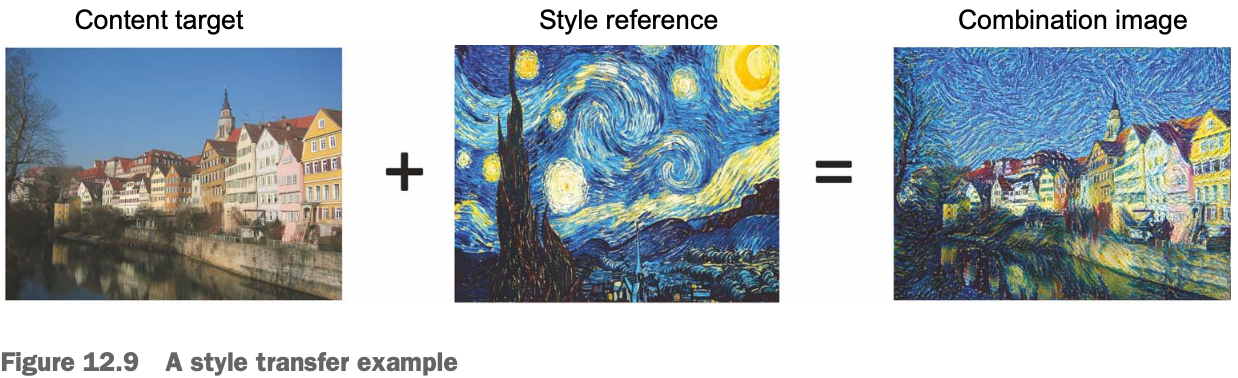

在这种情况下，风格本质上是指图像中各种空间尺度的纹理、颜色和视觉图案，内容是图像的更高层次的宏观结构。例如，蓝色和黄色的圆形笔触被认为是图12.9的风格（使用文森特·梵高的《星夜》），蒂宾根照片中的建筑物被认为是内容。

风格转移的想法与纹理生成密切相关，在2015年神经风格转移发展之前，在图像处理社区中有着悠久的历史。但事实证明，基于深度学习的风格转移实现提供了前所未有的经典计算机视觉技术所取得的成果，它们引发了计算机视觉创造性应用的惊人复兴。

实现风格迁移背后的关键概念是所有深度学习算法的核心想法：您定义一个损失函数来指定您想要实现的目标，并将此损失降至最低。我们知道我们希望实现什么：保存原始图像的内容，同时采用参考图像的样式。如果我们能够从数学上定义内容和样式，那么要最小化的适当损失函数如下：

```
loss = (distance(style(reference_image) - style(combination_image)) + distance(content(original_image) - content(combination_image)))
```

在这里，`distance` 是一个范数函数，如L2范数，`content` 是获取图像并计算其内容表示的函数，`style` 是获取图像并计算其风格表示的函数。最小化此损失会导致 `style(combination_image)` 接近 `style(reference_image)`，`content(combination_image)` 接近 `content(original_image)`，从而实现我们定义的风格迁移。

Gatys等人提出的一个基本观察是，深卷积中性网络提供了一种数学定义风格和内容函数的方法。让我们看看怎么做。

## 12.3.1 The content loss

如您所知，来自网络中早期层的激活包含有关图像的局部信息，而来自更高层的激活包含越来越全局的抽象信息。以不同的方式表述，convnet的差异层的激活提供了不同空间尺度上图像内容的分解。因此，您希望通过convnet中上层的表示捕获图像的内容，这些内容更具全局性和抽象性。

因此，内容损失的良好候选者是在预训练的convnet中上层的激活（在目标图像上计算）和在生成的图像上计算的同一层的激活之间的L2范数。这保证了从上层看到，生成的图像看起来与原始目标图像相似。假设convnet的上层看到的实际上是其输入图像的内容，这可以作为保存图像内容的一种方式。

## 12.3.2 The style loss

内容损失仅使用单个上层，但Gatys等人定义的风格损失使用convnet的多层：您尝试在convnet提取的所有空间尺度上捕获风格参考图像的外观，而不仅仅是单个尺度。对于风格损失，Gatys等人使用层激活的 `Gram matrix`：给定层特征映射的内积。

这个内积可以理解为表示层特征之间相关性的映射。特征相关性捕获特定空间尺度模式的统计数据，这些统计数据在经验上与该尺度上发现的纹理的外观相对应。

因此，风格损失旨在在不同层的激活中，在风格参考图像和生成的图像中保持类似的内部相关性。反过来，这保证了在不同空间尺度上发现的纹理在样式参考图像和生成的图像中看起来相似。

简而言之，您可以使用预训练的convnet来定义将执行以下操作的损失：

- 通过在原始图像和生成的图像之间保持类似的高级层激活来保存内容。Convnet应该“看到”原始图像和生成的图像包含相同内容。
- 通过在低层和高层的激活中保持相似的相关性来保留样式。特征相关性捕获纹理：生成图像和引用图像的风格应在不同的空间尺度上共享相同的纹理。

现在让我们看看原始2015年神经风格迁移算法的 Keras 实现。如您所见，它与我们在上一节中开发的 DeepDream 实现有很多相似之处。

## 12.3.3 Neural style transfer in Keras

神经风格迁移可以使用任何预训练的convnet实现。在这里，我们将使用Gatys等人使用的VGG19网络。VGG19是第5章中引入的VGG16网络的简单变体，他有额外的三个卷积层。

以下是一般流程：

- 建立一个网络，同时计算风格参考图像、基本图像和生成图像的VGG19层激活。
- 使用在这三张图像上计算的层激活来定义前面描述的损失函数，我们将将其最小化，以实现风格迁移。
- 设置梯度下降过程，以最小化此损失函数。

让我们从定义风格引用图像和基本图像的路径开始。为了确保处理后的图像大小相似（尺寸大体不同，使风格转移更加困难），我们稍后会将它们的大小调整为400像素的高度。

In [2]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

958464/943128 [==============================] - 1s 1us/step


我们的内容图像显示在图12.10中，图12.11显示了我们的风格图像。

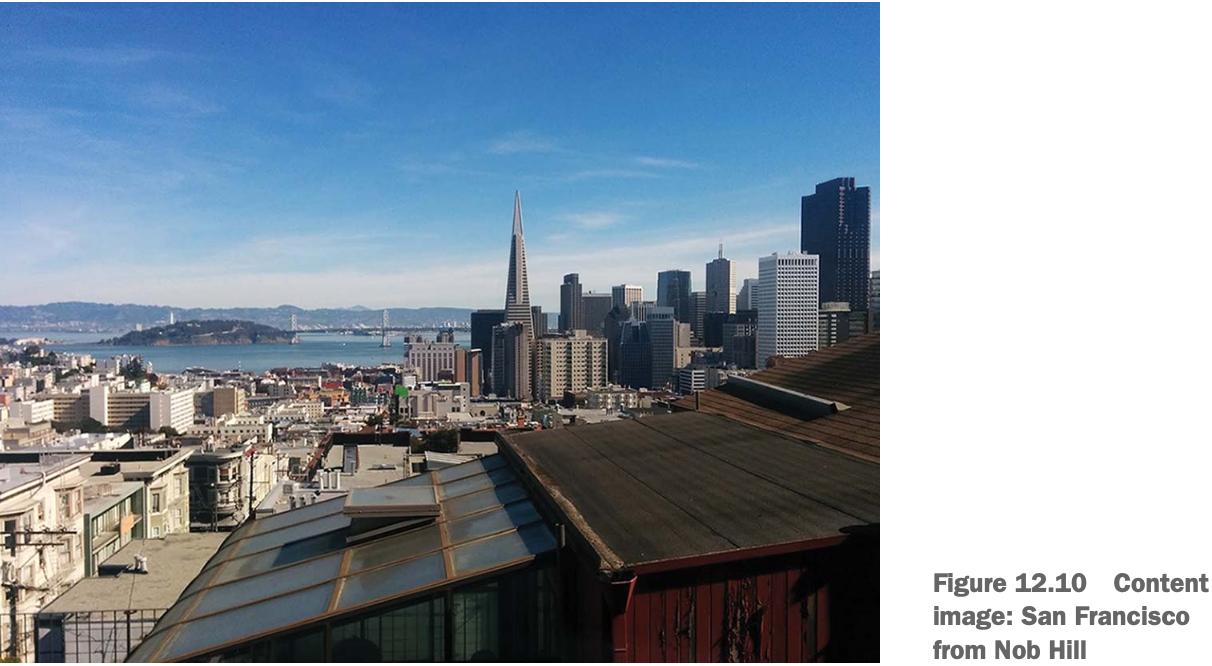

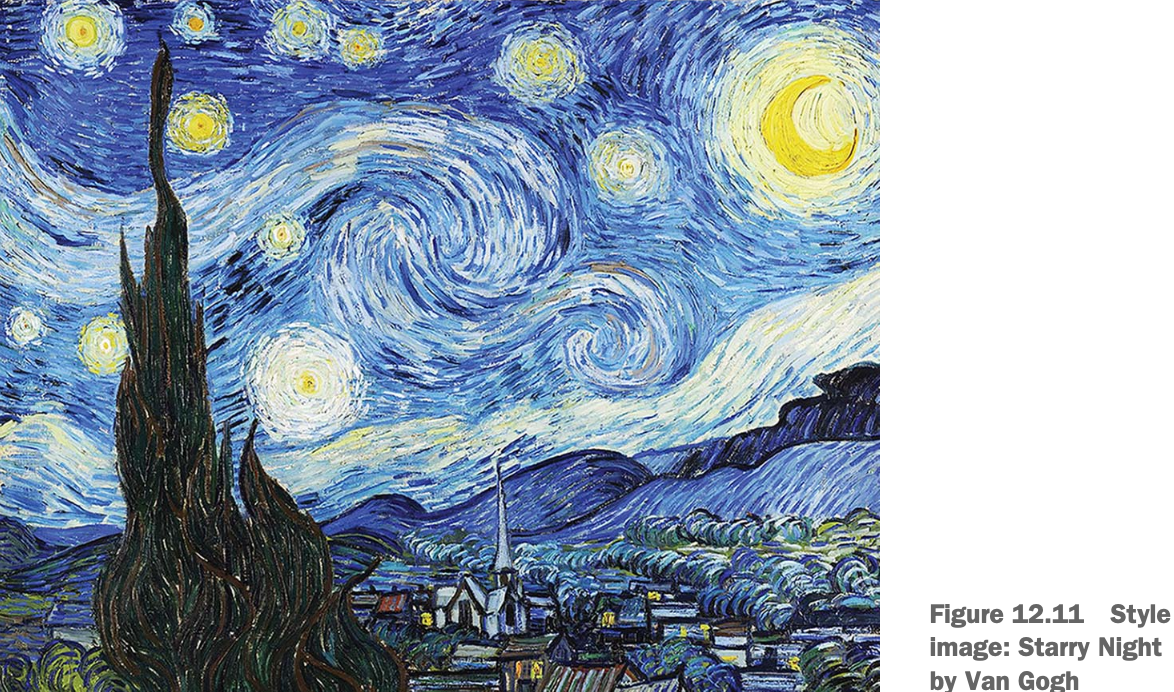

我们还需要一些加载、预处理和后处理的辅助函数。

In [ ]:
import numpy as np

def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

让我们设置VGG19网络。与 DeepDream 示例一样，我们将使用预先训练的convnet创建一个特征提取模型，这次该模型返回模型中的所有层的激活。

In [10]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

让我们定义内容损失，这将确保VGG19 convnet的顶层对风格图像和组合图像具有相似的视图。

In [11]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

接下来是风格损失。它使用辅助函数来计算输入矩阵的 `Gram Matrix`：原始特征矩阵中发现的相关性映射。

In [12]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1)) 
    gram = tf.matmul(features, tf.transpose(features)) 
    return gram

def style_loss(style_img, combination_img): 
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img) 
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

在这两个损失组件中，您添加第三个：total variation loss，它对生成的组合图像的像素进行操作。它鼓励生成图像的空间连续性，从而避免过度像素化的结果。您可以将其解释为正则化损失。

In [13]:
def total_variation_loss(x):
    a = tf.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :] 
    )
    b = tf.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))


您最小化的损失是这三种损失的加权平均值。要计算内容损失，您只使用一个顶层——`block5_conv2`层——而对于风格损失，您同时使用低层和高层的层列表。在末尾添加total variation loss。

根据您正在使用的风格参考图像和内容图像，您可能需要调整 `content_weight` 系数（内容损失对总损失的贡献）。更高的 `content_weight` 意味着目标内容在生成的图像中将更容易识别。

In [14]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

style_weight = 1e-6
content_weight = 2.5e-8 
def compute_loss(combination_image, base_image, style_reference_image): 
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0) 
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name] 
        style_reference_features = layer_features[1, :, :, :] 
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss( style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

最后，让我们设置梯度下降过程。在最初的Gatys等人论文中，优化是使用L-BFGS算法执行的，但这在TensorFlow中不可用，因此我们将使用SGD优化器进行迷你批量梯度下降。我们将利用您以前从未见过的优化特性： a learning-rate schedule。我们将使用它来逐渐将学习率从非常高的值（100）降低到更小的最终值（约20）。这样，我们将在训练的早期阶段取得快速进展，然后在接近最低损失时更加谨慎地进行。

In [ ]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(
    combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}, loss={loss:.2f}")
        img = deprocess_img(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.utils.save_img(fname, img)

2022-04-10 17:50:59.754481: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Iteration 100, loss=8138.08
Iteration 200, loss=6653.08
Iteration 300, loss=6063.16
Iteration 400, loss=5742.66
Iteration 500, loss=5536.25
Iteration 600, loss=5390.38


图12.12显示了你得到什么。请记住，这种技术实现的只是一种图像纹理重塑或纹理转移的形式。它最适合具有强烈纹理和高度自相似性的风格参考图像，以及不需要高细节即可识别的内容目标。它通常无法实现相当抽象的壮举，例如将一幅肖像的风格转移到另一幅肖像。算法更接近经典的信号处理，而不是人工智能，所以不要指望它像魔法一样工作！

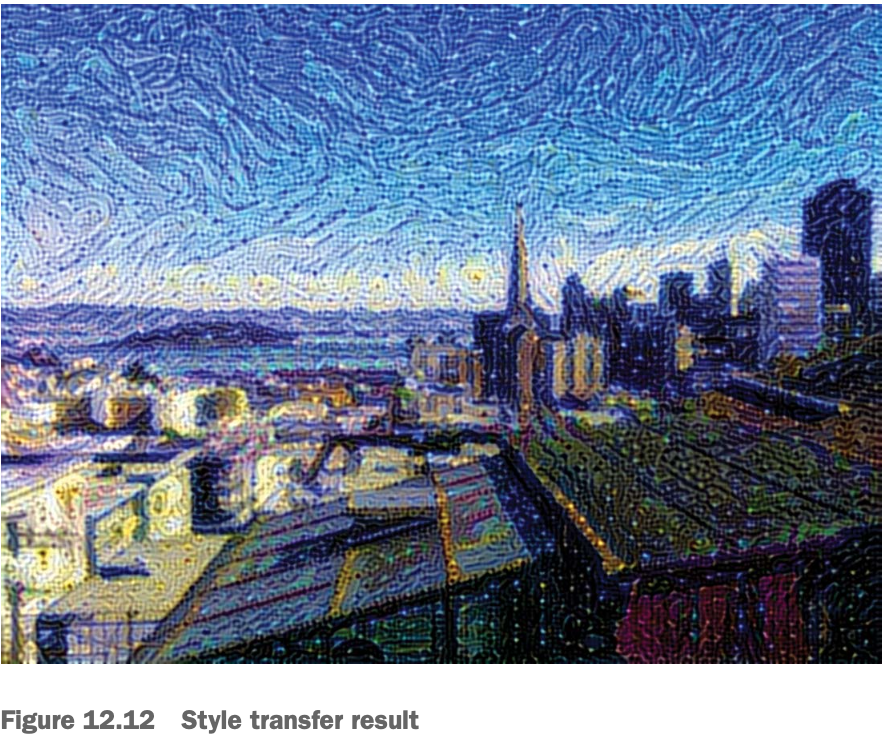

此外，请注意，此样风格迁移算法运行缓慢。但由设置操作的转换足够简单，可以通过一个小的，快速地前向卷积网络实现 —— 只要您有合适的训练数据。快速地风格迁移可以通过首先固定风格图像， 花费大量的计算循环生成输入-输出的训练样本， 然后通过训练一个简单的卷积网络学习这种风格特定的转换。完成后，对给定图像的风格化是瞬间的：它只是这个小convnet的向前传递。

## 12.3.4 Wrapping up

- 风格迁移包括创建一个新图像，该图像保留目标图像的内容，同时捕获参考图像的风格。
- 内容可以通过convnet的高层激活捕获。
- 风格可以通过捕获convnet的不同层级激活的内部相关性得到。
- 因此，深度学习允许将风格迁移表述为一种优化使用预训练convnet定义的损失的过程。
- 从这个基本想法出发，许多变体和改进是可能的。